# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add HyperbolicsLCS folder to current working path
sys.path.append(parent_directory+"/demos/DiffusionBarriers/EllipticLagrangianDiffusionBarriers")

Wall time: 0 ns


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we extract elliptic LCS in the Agulhas region from the AVISO dataset. The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
<br />
* Define computational parameters (such as the number of cores) and variables
 <br />
* Define spatio-temporal domain over which to compute the elliptic LCS.
 <br />
* Interpolate velocity from the (discrete) gridded data using a cubic spline interpolation <br />
* Compute rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $ over meshgrid of initial conditions '$ \mathbf{x} $' at time '$t$' <br />
* Compute elliptic LCS as closed null geodesics of $ \mathbf{C}_{t_0}^t(\mathbf{x}, t)-\mu I $.

# Import Data

We start by import the AVISO-data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'.

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/processed_data/AVISO.mat')

U = mat_file['vx'].transpose()
V = mat_file['vy'].transpose()
x = mat_file['xc'].transpose()
y = mat_file['yc'].transpose()
time_data = mat_file['time'].reshape(1,-1)

Wall time: 37.9 ms


# Data/Parameters for Dynamical System

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 8

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-Temporal Domain of Dynamical System

In [5]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 20

# time step-size
dt = .1

# tN-t0
lenT = tN-t0

time = np.arange(t0, tN+dt, dt)

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -28

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 0 ns


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

Wall time: 67.8 ms


#  Diffusion averaged Cauchy Green (CG) strain tensor

Next, we compute the diffusion averaged Cauchy Green strain tensor $ \mathrm{\overline{C}_{D}}_{t_0}^{t_N}(\mathbf{x}_0) $ over the time-interval $ [t_0, t_N] $ by iterating over a meshgrid (parallelized). 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid when computing spatial derivatives. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $.

In [7]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package for computing trajectories/velocity
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import Rate of Strain function
from ipynb.fs.defs.DiffusionCauchyGreen import DiffusionCauchyGreen

# Import RegularGridInterpolator
from scipy.interpolate import RegularGridInterpolator

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

# number of diffusive Cauchy Green strain tensor
n_averaging = 10

# Components of diffusivity tensor D11, D12, D22 over spatial meshgrid and time have shape (Ny, Nx, N)
# , where Ny/Nx are the spatial resolution in the lat/long coordinates
# and N the time-resolution of the data
D11_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1]))
D12_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1]))
D22_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1]))

# Diffusivity Tensor (we set it to be constant in space and time 
# but it can generally be anisotropic and temporally varying)
D11 = 2
D12 = 0
D22 = 0.5
D11_field[:,:,:] = D11
D12_field[:,:,:] = D12
D22_field[:,:,:] = D22

# Interpolate D11_field/D12_field/D22_field over spatial and temporal domain
Interpolant_D11 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D11_field)
Interpolant_D12 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D12_field)
Interpolant_D22 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D22_field)

def parallel_Cd(i):
    
    Cd_parallel = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(Cd_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # compute trajectory
        Fmap = integration_dFdt(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[0]
        
        # Compute gradient of flowmap
        gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
        # Compute diffusion averaged CG tensor
        Cd_parallel[j, :, :] = DiffusionCauchyGreen(Interpolant_D11, Interpolant_D12, Interpolant_D22, time, Fmap, gradFmap, lenT, n_averaging)
    
    return Cd_parallel

Cd = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_Cd)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/201 [00:00<?, ?it/s]

Wall time: 5min 59s


# Compute Tensorfield properties

We now compute the properties of the rate of strain tensor 'S' such as the eigenvalues 's1', 's2' and eigenvectors 'eigenv1', 'eigenv2'. Furthermore, we also need the spatial derivatives of the elements of 'S'.

In [8]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute gradients of elements of rate of strain tensor

# Initialize array
Cd11 = np.nan_to_num(Cd[:,:,0,0], nan=0.0)
Cd12 = np.nan_to_num(Cd[:,:,0,1], nan=0.0)
Cd22 = np.nan_to_num(Cd[:,:,1,1], nan=0.0)
    
# Interpolate elements of rate of strain tensor (per default: cubic)
interp_Cd11 = RBS(Y_domain[:,0], X_domain[0,:], Cd11)
interp_Cd12 = RBS(Y_domain[:,0], X_domain[0,:], Cd12)
interp_Cd22 = RBS(Y_domain[:,0], X_domain[0,:], Cd22)

# Initialize arrays
Cd11x = np.zeros((Cd.shape[0], Cd.shape[1]))*np.nan
Cd11y = np.zeros((Cd.shape[0], Cd.shape[1]))*np.nan
Cd12x = np.zeros((Cd.shape[0], Cd.shape[1]))*np.nan
Cd12y = np.zeros((Cd.shape[0], Cd.shape[1]))*np.nan
Cd22x = np.zeros((Cd.shape[0], Cd.shape[1]))*np.nan
Cd22y = np.zeros((Cd.shape[0], Cd.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        Cd11x[i, j] = (interp_Cd11(x[1], x[0]+rho_x)[0][0]-interp_Cd11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        Cd11y[i, j] = (interp_Cd11(x[1]+rho_y, x[0])[0][0]-interp_Cd11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        Cd12x[i, j] = (interp_Cd12(x[1], x[0]+rho_x)[0][0]-interp_Cd12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        Cd12y[i, j] = (interp_Cd12(x[1]+rho_y, x[0])[0][0]-interp_Cd12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        Cd22x[i, j] = (interp_Cd22(x[1], x[0]+rho_x)[0][0]-interp_Cd22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        Cd22y[i, j] = (interp_Cd22(x[1]+rho_y, x[0])[0][0]-interp_Cd22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [9]:
%%time
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, Cd11, Cd12, Cd22, Cd11x, Cd11y, Cd12x, Cd12y, Cd22x, Cd22y)

Wall time: 1.3 s


# Find closed null-geodesics of $ \mathrm{\overline{C}_{D}}_{t_0}^{t_N}(\mathbf{x}_0) − \mathcal{T}_0 I $

Elliptic Lagrangian diffusion barriers are closed null geodesics of the one-parameter family of Lorentzian metrics $ \mathrm{\overline{C}_{D}}_{t_0}^{t_N}(\mathbf{x}_0) − \mathcal{T}_0 I $. $ \mathcal{T}_0 ∈ \mathbb{R} $ denotes the tangential stretching rate along an elliptic Lagrangian diffusion barrier. 

In [10]:
%%time
# Import function to compute closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import _closed_null_geodesics

# extract elliptic LDB as closed null geodesics
from ipynb.fs.defs.elliptic_LDB import _elliptic_LDB

# define T0 range
T_min = 0.5
T_max = 2
n_T = Ncores
T_range = np.linspace(T_min, T_max, n_T)

# parameter specifying sparsity of initial conditions. 
# Increasing this parameter reduces the number of initial conditions and thereby reduces the computational time involved.
# For maximal accuracy set sparse_ic = 1. This implies that we use the resolution of the meshgrid. 
# This value should always be at least 1.
sparse_ic = 1

# threshold distance for periodicity of trajectory
d_threshold = dx

# compute Elliptic Lagrangian diffusion barrier (LDB)
elliptic_LDB = []

# Initial conditions of T
init_T_range = []

for T in T_range:
    
    print("Compute elliptic LDB for T =", np.around(T, 3))
    
    # Define list storing x, y coordinates of elliptic LDB
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_null_geodesics, init_T = _closed_null_geodesics(X_domain, Y_domain, T, interp_phi_prime, d_threshold, Cd11, interp_DOE, sparse_ic)
    
    # Append initial conditions to list 
    init_T_range.append(init_T)
        
    # Extract elliptic LDB
    x_elliptic, y_elliptic = _elliptic_LDB(closed_null_geodesics)
           
    elliptic_LDB.append([x_elliptic, y_elliptic])

ImportError: cannot import name '_elliptic_LDB' from 'ipynb.fs.defs.elliptic_LDB' (unknown location)

NameError: name 'T_range' is not defined

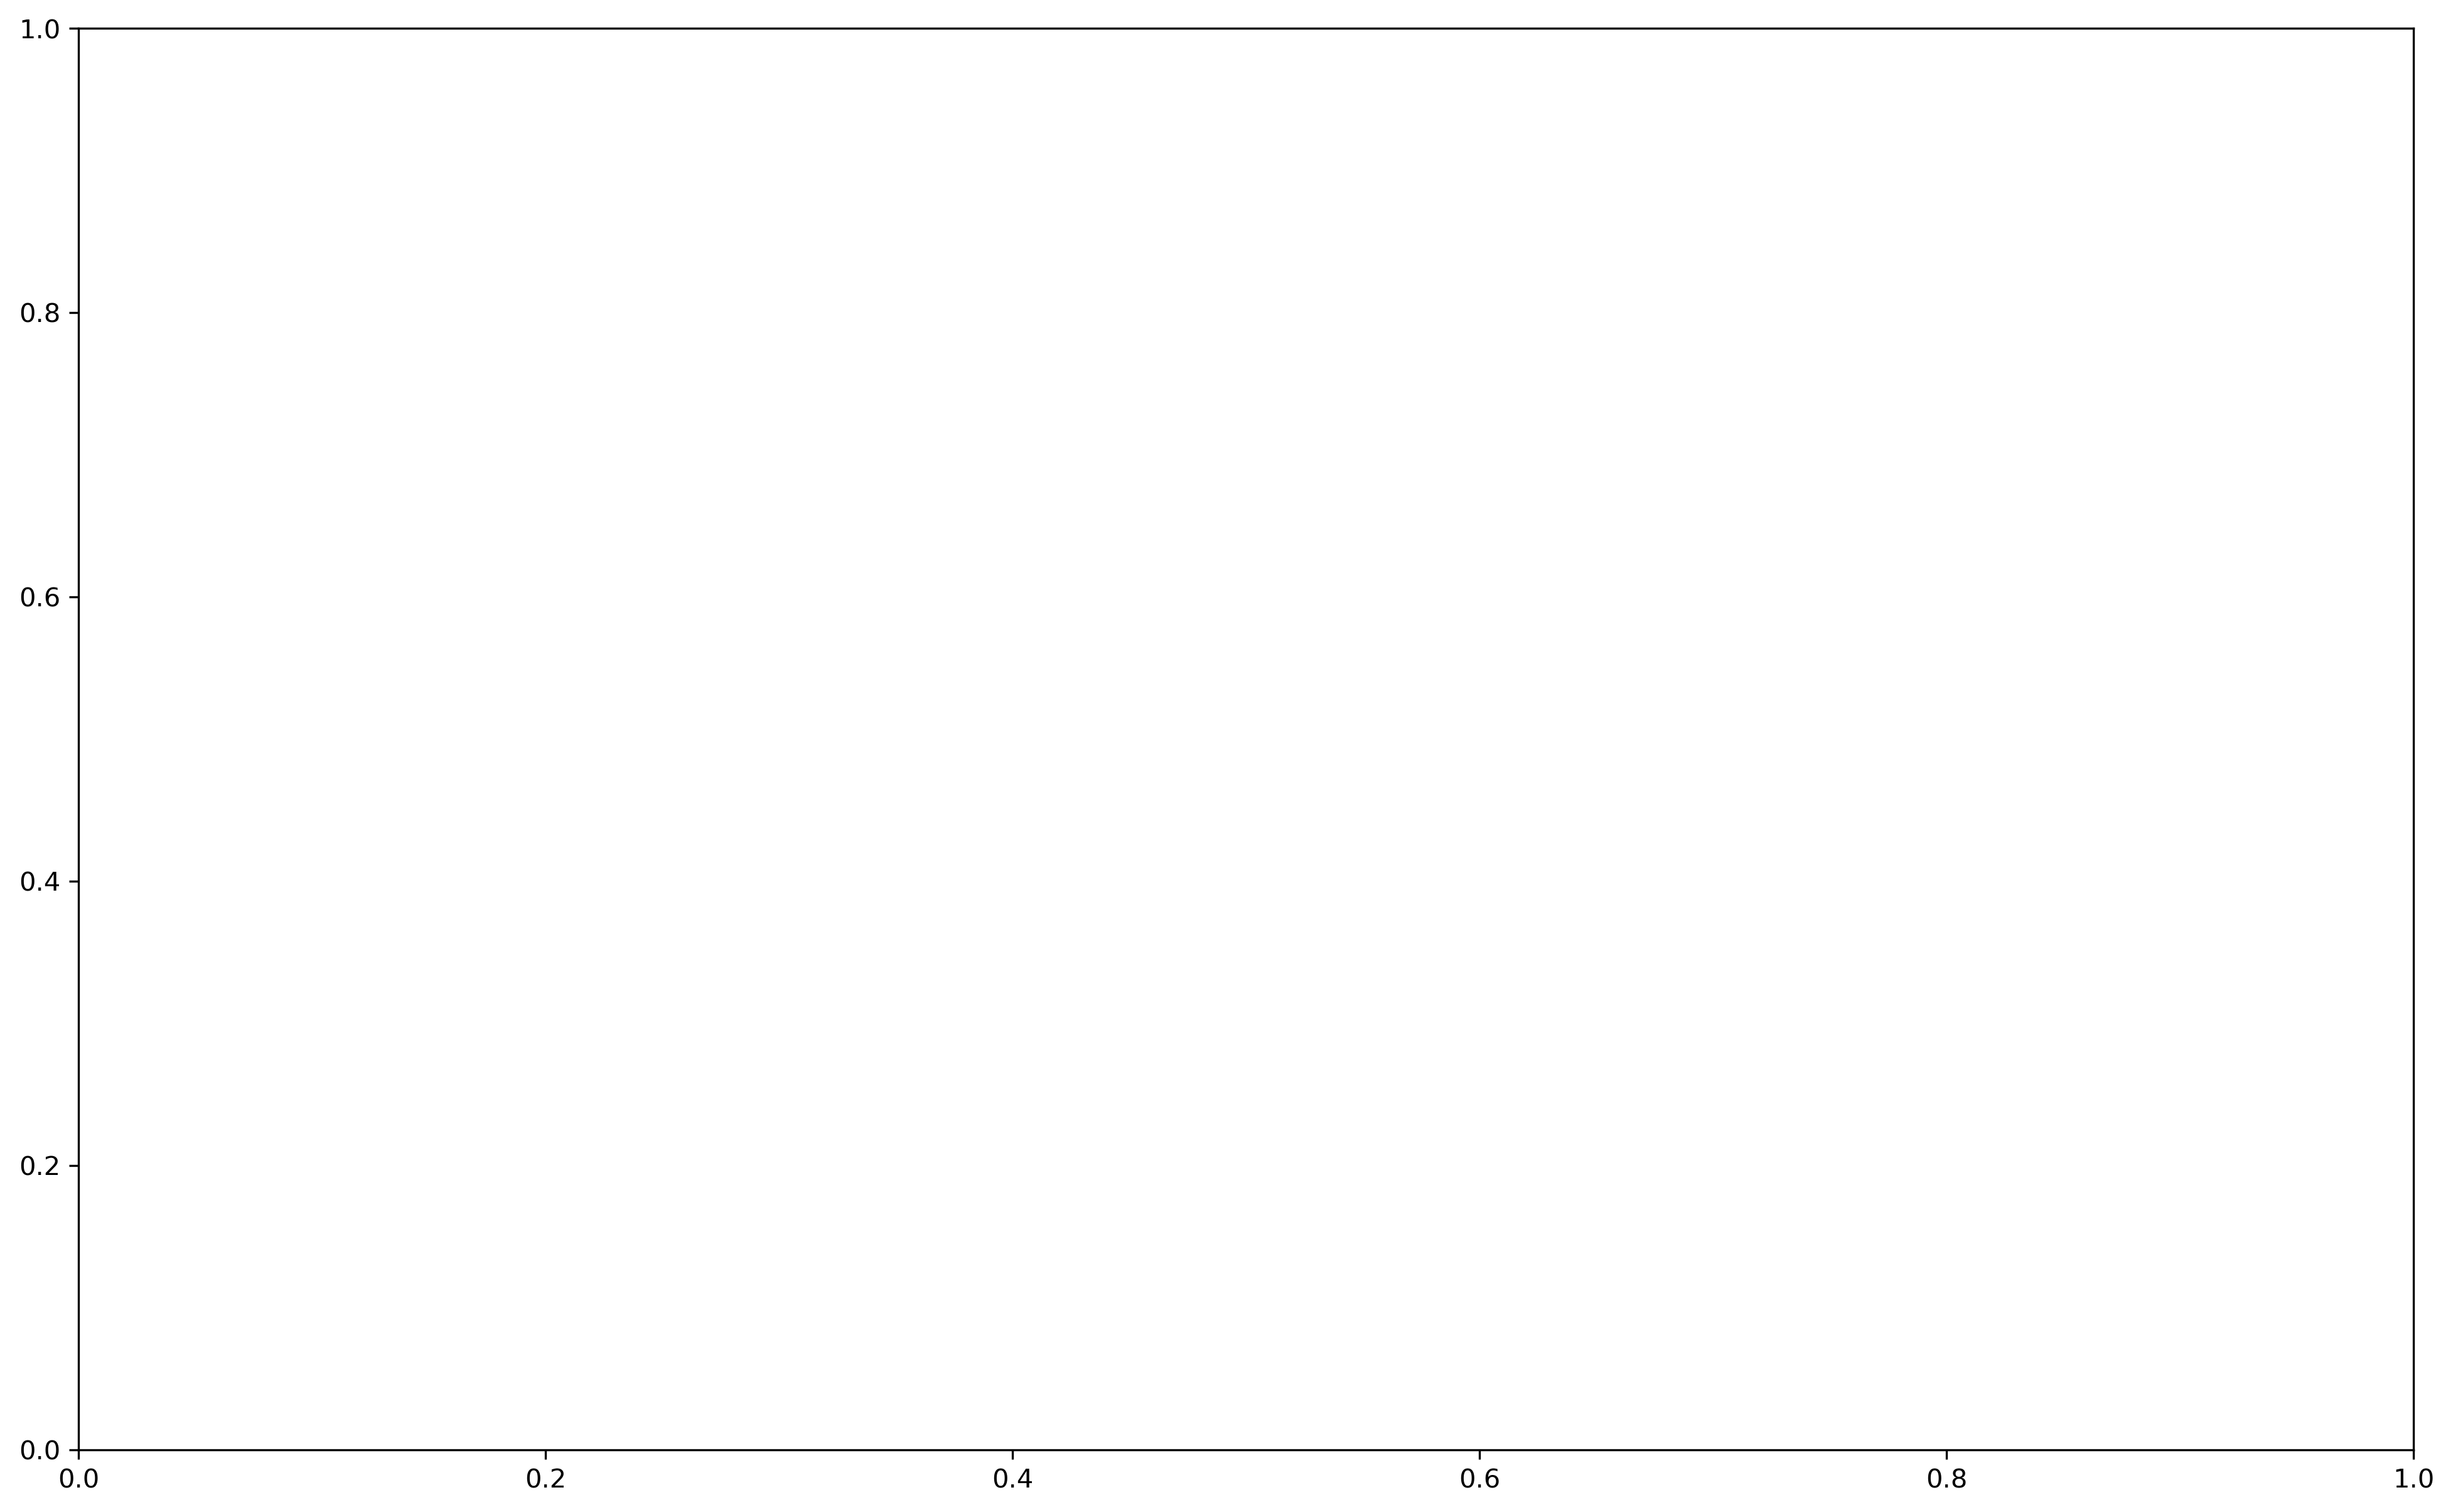

In [11]:
######################################## Plot elliptic LDB ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=T_range.min(), vmax=T_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic LDB and plot
for i in range(len(elliptic_LDB)):
    
    ax.scatter(init_T_range[i][0], init_T_range[i][1], s = 1, color=cmap.to_rgba(T_range[i]))
    
    if elliptic_LDB[i][0] is not None:
    
        for j in range(len(elliptic_LDB[i][0])):
        
            if elliptic_LDB[i][0][j] is not None:
        
                ax.plot(elliptic_LDB[i][0][j], elliptic_LDB[i][1][j], c=cmap.to_rgba(T_range[i]), linewidth = 2)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[T_range.min(), 1, T_range.max()])
cbar.ax.set_ylabel(r'$ \mathcal{T}_0 $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Elliptic LDB", fontsize = 20)
plt.show();

The colored dashed lines indicate the location of the initial conditions satisfying:

\begin{equation}
\mathrm{\overline{C}_{D}^{11}}_{t_0}^{t_N}(\mathbf{x}_0) - \mathcal{T}_0^2 = 0
\end{equation}